# 10. 나를 찾아줘 - Class Activation Map 만들기

## 9. 프로젝트: CAM을 만들고 평가해 보자

### 준비물
---
개인 실습 환경에 따라 경로를 수정, 터미널을 열고 프로젝트를 위한 디렉토리를 생성하자.

```bash
$ mkdir -p ~/AIFFEL/Going_Deeper/GD10_Detection_with_CAM/class_activation_map
```

클라우드 사용자라면 우측 하단의 Cloud shell을 열고 디렉토리를 생성하자.

```bash
$ ln -s ~/data ~/AIFFEL/Going_Deeper/GD10_Detection_with_CAM/class_activation_map
```

## CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기
__CAM(Class Activation Map)__은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있다. 반면에 Grad-CAM은 이러한 제약이 없다.

우리는 이번 시간에 두 가지를 모두 구현해 보겠다.<br>
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문이다.

CAM은 **클래스에 대한 활성화 정도를 나타낸 지도**이다. 따라서 기본적으로 우리의 모델은 **분류(classfication)**를 수행하는 모델이어야 한다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 한다.

**`Tensorflow Datasets`**의 카탈로그에서 이러한 데이터를 확인할 수 있는데, 여기서는 **`Cars196`** 데이터셋을 사용하겠다. 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 **바운딩 박스(bounding box)** 정보를 포함하고 있다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠다.

* [Cars196 in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/cars196)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

`cars196` 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어있다. `tfds.load()`를 활용해서 데이터셋을 다운로드 해자.

> _(주의) 아래 데이터셋은 총 사이즈 1.8GB에 이르는 대용량 데이터셋이다. 최초로 load()를 호출하는 경우 다운로드에 1시간 가량 소요될 수 있다._

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

`tfds.show_examples()` 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있다.

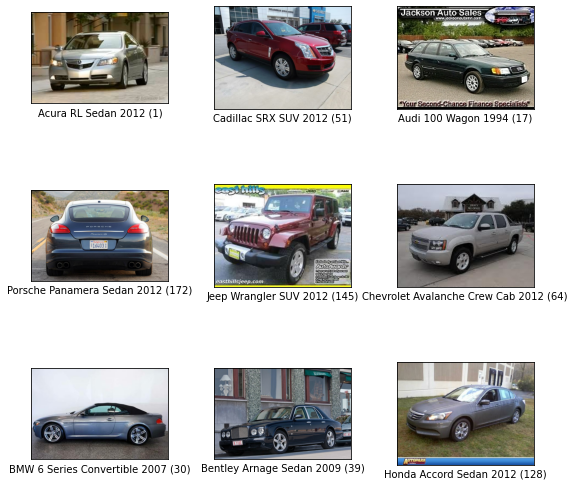

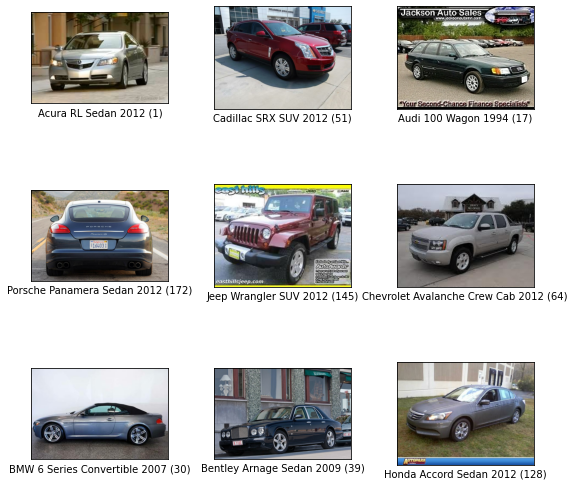

In [5]:
tfds.show_examples(ds_train, ds_info)

학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인해보자.

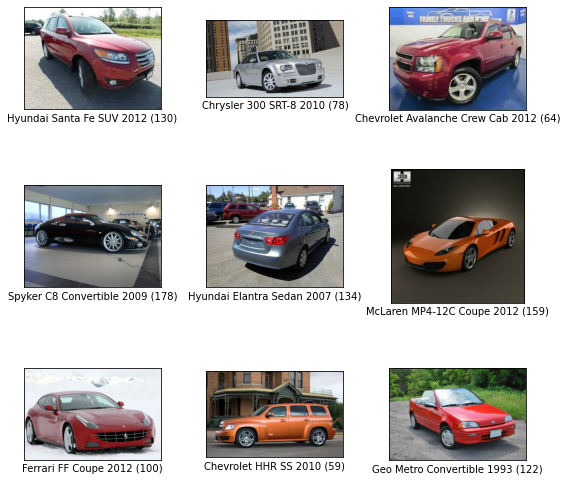

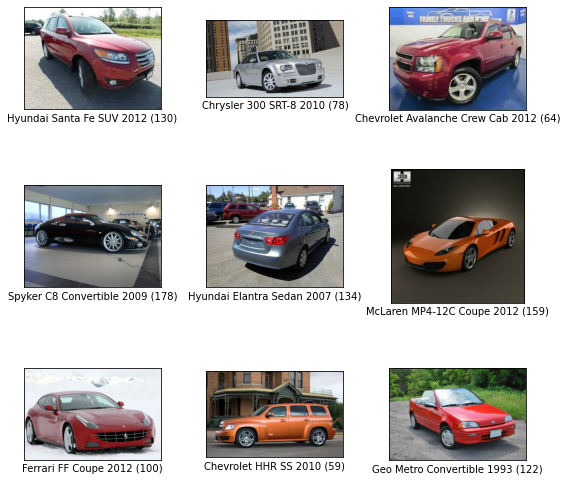

In [6]:
tfds.show_examples(ds_test, ds_info)

## CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보
원본 이미지 위에 물체의 위치정보는 어떻게 시각화 하여 표시할 수 있을까? 데이터셋의 메타 정보인 `df_info`를 조회해 `features`가 어떻게 구성되어 있는지 확인해보자.

In [7]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

먼저 `image`와 `label`은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스이다. 그런데 조금 새로운 키(key)가 있다. `bbox`는 무엇일까? `bbox`(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법이다. 위에서 확인한 바로는 `BBoxFeature`이라는 타입으로 정의되어 있다.

(참고) [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

<img src="./image/bbox.jpg" />

#### 바운딩 박스를 표시하는 방법들
바운딩 박스를 라벨링하는 방법은 아주 다양하다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법이다.

* __'xywh'__ 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법이다.
    - (예) `(x_center, y_center, width, height)`
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다.
* __'minmax'__는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다.
    - (예) `(x_min, x_max, y_min, y_max)`
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적이다.
* 위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋다.

#### 주어진 데이터셋에서 BBoxFeature 타입으로 표기된 bbox 필드는 어떤 방식으로 바운딩박스를 라벨링할까?  (참고)로 제시된 텐서플로우 튜토리얼 링크를 통해 확인해보자.

* 해당 bounding box는 minmax를 의미한다. 
* tfds의 경우 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미하게 된다.

## CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠다. 이번에는 미리 이미지넷(`imagenet`) 데이터에 훈련된 `resnet50`을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어이다.

__구현해 보기__

아래에서 직접 `resnet50` 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성하자. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해보자.

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 한다. 우리의 경우 `keras.application`의 `ResNet50`의 매개변수 `pooling`에 `'avg'`를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있다.

* 참고: [tf.keras.applications.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

직접 만든 CAM모델을 확인해보자.

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

__CAM은 특성 맵(feature map)을 사용해 만든다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까? 해당 레이어의 이름을 찾아보자.__

* conv5_block3_out의 output이 feature map이 된다. 
* 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 된다.

## CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기
이제 학습을 위한 과정은 이전과 비슷하다.

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 `normalize_and_resize_img()` 에서 수행하며, 이를 포함하여 `apply_normalize_on_dataset()`에서 배치를 구성한다.

`input`에 이전과 다르게 `bbox` 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 `normalize_and_resize_img`과정에서 제외해 주었다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문이다.

In [10]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


이제 모델을 컴파일하고 학습시킨다. 학습에는 20~30분 가량 소요될 것이다.

In [12]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 117s 176ms/step - loss: 4.9757 - accuracy: 0.0583 - val_loss: 5.3931 - val_accuracy: 0.0072
Epoch 2/15
509/509 [==============================] - 87s 170ms/step - loss: 2.1208 - accuracy: 0.5470 - val_loss: 2.1331 - val_accuracy: 0.4735
Epoch 3/15
509/509 [==============================] - 85s 167ms/step - loss: 0.7498 - accuracy: 0.8609 - val_loss: 1.3942 - val_accuracy: 0.6394
Epoch 4/15
509/509 [==============================] - 101s 198ms/step - loss: 0.2082 - accuracy: 0.9799 - val_loss: 1.1427 - val_accuracy: 0.7024
Epoch 5/15
509/509 [==============================] - 87s 171ms/step - loss: 0.0773 - accuracy: 0.9969 - val_loss: 1.0997 - val_accuracy: 0.7090
Epoch 6/15
509/509 [==============================] - 85s 168ms/step - loss: 0.0367 - accuracy: 0.9992 - val_loss: 1.0925 - val_accuracy: 0.7186
Epoch 7/15
509/509 [==============================] - 86s 170ms/step - loss: 0.0301 - accuracy: 0.9985 - val_loss: 1.0855 - val_

학습시킨 가중치를 저장해 주겠다.

In [14]:
import os

cam_model_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD10_Detection_with_CAM/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

저장 완료!


## CAM
이제 학습한 모델을 활용하여 CAM을 생성해 볼 것이다. 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권장한다.

In [3]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

이제 학습된 모델에서 CAM을 생성해보자. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one() `함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했다.

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

29


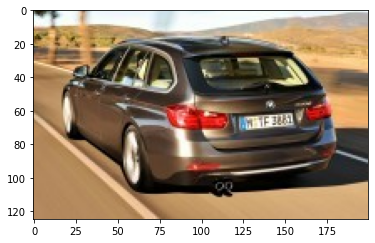

In [5]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이제 데이터가 준비되었으니 CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러와보자.

In [6]:
import os
cam_model_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD10_Detection_with_CAM/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 __(1) 특성 맵, (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값__이 필요하다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것이다. 이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.

`generate_cam()` 을 구현하기 위해 아래에서는 `conv_ouputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 `resize` 해주었다.

In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있다. 생각보다 위치를 정확하게 표현하고 있다.

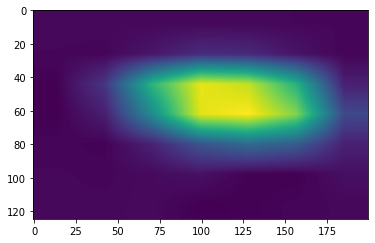

In [8]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐보자.

In [9]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

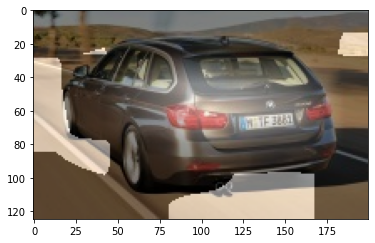

In [10]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

어떤가? 생성된 CAM이 차종을 식별하는데 중요한 이미지 부분을 잘 포착하고 있다. 주로 차량의 전면 엠블럼이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 차종을 식별할 때 유의해서 보는 부분과 일맥상통하다는 것을 확인할 수 있을 것이다.

## 7. Grad-CAM
이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 `cam_model`을 그대로 활용하자.

우선 새로운 이미지를 뽑아보자.

56


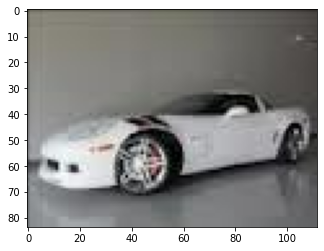

In [11]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이번에는 Grad-CAM을 이용해서 CAM을 만들어보자.

`grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(`weights`)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 `cam_image`를 얻게 된다.

위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 한다.

아래 `generate_grad_cam()`에서는 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`을 얻고 이를 `weights`로 활용한다.

In [12]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보자! 레이어의 이름은 `cam_model.summary()`에서 찾을 수 있다.

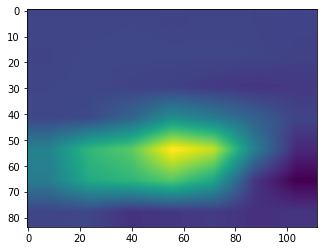

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

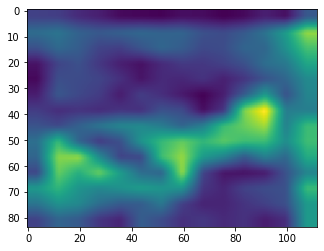

In [14]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

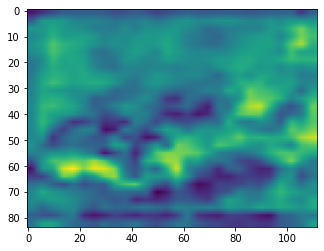

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## 8. Detection with CAM

### 바운딩 박스
---
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠다.

52


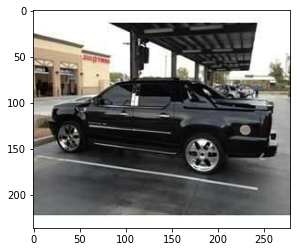

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

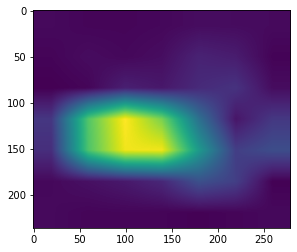

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전의 `generate_cam`을 활용해서 CAM 이미지를 뽑아보자. 아래 `get_bbox()` 함수는 바운딩 박스를 만들기 위해서 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앤다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾는다. 이때 `rotated_rect` 라는 회전된 바운딩 박스를 얻을 수 있다. `boxPoints()`로 이를 꼭지점으로 바꾸어준다. 마지막에는 `int` 자료형으로 변환해준다.

In [18]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

아래에서 `cam_image`를 통해 `bbox`를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있다.

In [19]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[  0, 209],
       [  0,  33],
       [277,  33],
       [277, 209]])

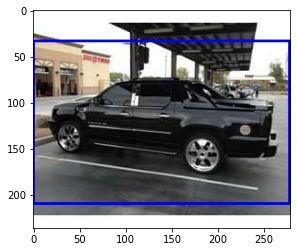

In [20]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### Intersection Over Union
---
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있다. 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까?

<img src="./image/iou.jpg" />

__IoU(Intersection over Union)__는 두 개 영역의 합집합인 __"union"__ 영역으로 교집합 영역인 __"intersection"__ 영역의 넓이를 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

자세한 내용이 궁금하시다면 아래 링크를 참조.

* [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE&ab_channel=DeepLearningAI)

In [21]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

위에서 구했던 `rect`를 minmax `bbox` 형태로 치환해보자.

In [22]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.13983050847457626, 0.0, 0.885593220338983, 0.992831541218638]

이 데이터의 ground truth bbox를 확인해보자.

In [23]:
item['bbox']

array([0.31355932, 0.0609319 , 0.7627119 , 0.953405  ], dtype=float32)

어떤가? CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 얼마나 유사한지를 IoU를 계산해서 확인해보자.

In [24]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [25]:
get_iou(pred_bbox, item['bbox'])

0.5413931928401429

----

In [26]:
import os
cam_model_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD10_Detection_with_CAM/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM 구현하기
---
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해보자. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현하자.

```python
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```

2) 만든 함수로 CAM 이미지를 생성한다.

```python
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수를 만들어보자.

* 참고: [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

```python
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image
```

```python
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

In [27]:
#  CAM을 직접 구현
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

130


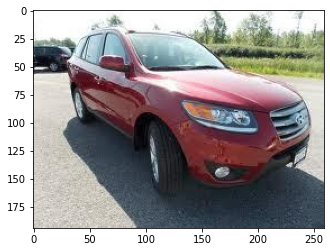

In [29]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

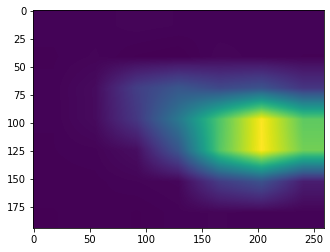

In [30]:
# 만든 함수로 CAM 이미지를 생성합시다.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

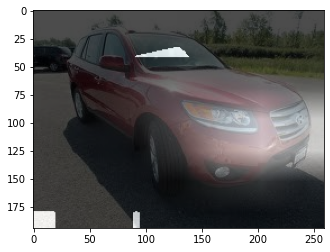

In [31]:
# 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수
def visualize_cam_on_image(src1, src2, alpha=0.7):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

In [32]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [33]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 62, 173],
       [ 62,  46],
       [257,  47],
       [257, 173]])

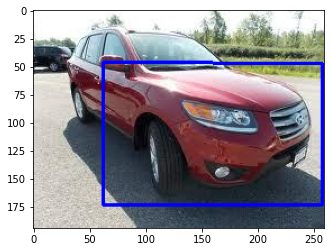

In [34]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### Grad-CAM 구현하기
---
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해보자. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해보자.

```python
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보자.

3) 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화해보자.

In [35]:
# Grad-CAM 구현하기
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

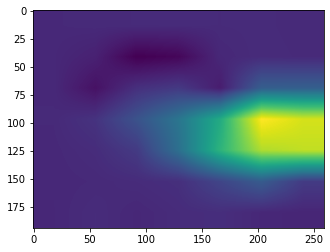

In [36]:
# CAM 이미지를 뽑아서 직접 확인
# 이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 cam_model.summary()에서 찾을 수 있습니다.
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

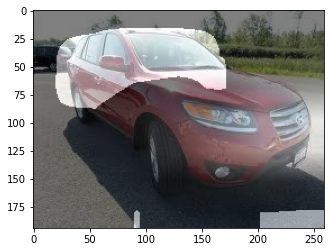

In [37]:
# visualize_cam_on_image() 함수로 이미지를 시각화
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

### 바운딩 박스 구하기
---
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보자.

2) 1)에서 얻은 바운딩 박스를 시각화해보자.

In [38]:
def get_bbox_grad(grad_cam_image, score_thresh=0.05):
    low_indicies = grad_cam_image <= score_thresh
    grad_cam_image[low_indicies] = 0
    grad_cam_image = (grad_cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [39]:
image = copy.deepcopy(item['image'])
rect_grad = get_bbox_grad(grad_cam_image)
rect_grad

array([[ 60, 171],
       [ 60,  46],
       [257,  47],
       [257, 171]])

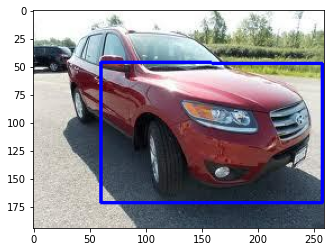

In [40]:

image = cv2.drawContours(image,[rect_grad],0,(0,0,255),2)
plt.imshow(image)

### IoU 구하기
---
1) __정답 바운딩 박스(ground truth)__와 __예측값 바운딩 박스(prediction box)__ 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수를 만들자.

```python
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해보자.

In [41]:
# IoU 구하기
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

# rect를 minmax bbox 형태로 치환해 봅시다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.23711340206185566,
 0.23938223938223938,
 0.8917525773195877,
 0.9922779922779923]

In [42]:
def rect_to_minmax_grad(rect_grad, image):
    bbox = [
        rect_grad[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect_grad[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect_grad[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect_grad[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

pred_bbox_grad = rect_to_minmax_grad(rect_grad, item['image'])
pred_bbox_grad

[0.23711340206185566,
 0.23166023166023167,
 0.8814432989690721,
 0.9922779922779923]

In [43]:
# 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [44]:
# 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.
get_iou(pred_bbox, item['bbox'])  # CAM

0.664952862291451

In [45]:
get_iou(pred_bbox_grad, item['bbox']) # Grad-CAM

0.6791798936272572

# Segmentation에 XAI를 적용해보기

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

In [46]:
dir_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD8_Segmentation2/semantic_segmentation/data/training'
unet_model_path = dir_path +'/seg_model_unet.h5'
model_unet = tf.keras.models.load_model(unet_model_path)

In [48]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [49]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                  Resize(
                      width=224,
                      height=224
                      )
                  ])

In [54]:
test_preproc = build_augmentation(is_train=False)

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

In [52]:
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

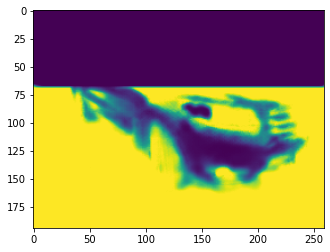

In [56]:
grad_cam_image = generate_grad_cam(model_unet, 'conv2d_19', item)
plt.imshow(grad_cam_image)

### 회고
---
* SIA 프로젝트 할때 도움이 될만한 노드였다.
* XAI에 관심이 많이 생겨서 더 깊게 파고 싶다.
* Segmentation에 XAI를 적용해보았다.

### 루브릭
---
* CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?<br>
(_ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다._)

    * __Output이 적당히 잘 나왔다.__

* 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?<br>
(_CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다._)
    
    * __시각화하였을 때 해당 object의 주요 특징 위치를 잘 보여주었다.__

* 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?<br>
(_CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다._)
    
    * __IoU 계산 과정을 통해 CAM과 Grad-CAM를 비교했다.__